`conda activate imgpro`

# Coding Directions Analysis

Compute and visualize coding directions


# 1. Imports and Configuration

In [82]:
import sys
import os
import glob
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple, Optional, Literal, Dict, Any, List
from dataclasses import dataclass
from scipy import stats

%matplotlib widget

# Configure matplotlib
font = {'family': 'Arial', 'weight': 'normal', 'size': 20}
matplotlib.rc('font', **font)

# ============================================================================
# CONFIGURATION - Edit these parameters
# ============================================================================

@dataclass
class Config:
    """Configuration for coding direction analysis."""
    # Data path
    # data_path: str = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
    data_path: str = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004'
    
    # Timing parameters
    fps: float = 1 / 0.533
    bin_factor: int = 2
    
    # # Epoch windows (frame indices) for date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
    # baseline_window: Tuple[int, int] = (10, 60)
    # pre_window: Tuple[int, int] = (82, 123)
    # post_window: Tuple[int, int] = (141, 181)
    # good_frames: Optional[List[int]] = range(0,1200) # List of good frames to use, or None to use all frames in the epoch windows
    # Epoch windows (frame indices) for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm00
    baseline_window: Tuple[int, int] = (500, 540)
    pre_window: Tuple[int, int] = (564, 601)# (575, 635)
    post_window: Tuple[int, int] = (678, 705)
    good_frames: Optional[List[int]] = range(baseline_window[0], 1100)  # List of good frames to use, or None to use all frames in the epoch windows
    
    # Preprocessing
    # rfp_thresh: float = 50  # RFP intensity threshold for mask (for date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001)
    rfp_thresh: float = 20  # RFP intensity threshold for mask (for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004)
    keep_width: Tuple[int, int] = (25, 228)  # X-range to keep
    zero_prob_thresh: float = 1 # in percent, masks voxels that are zero more than this percent of timepoints. registered data has regions of the worm cut off that are inside the mask and vary across z-planes and recording

    # Analysis options
    top_n_voxels: Optional[int] = 10000  # None = use all voxels, int = use top N most variable
    preprocess_method: Literal['raw', 'zscore', 'center'] = 'raw'  # 'raw' = R/R0, 'zscore', 'center' = mean-centered

config = Config()
print(f"Data path: {config.data_path}")
print(f"Preprocessing: {config.preprocess_method}")
print(f"Top N voxels: {config.top_n_voxels or 'all'}")

Data path: D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004
Preprocessing: raw
Top N voxels: 10000


# 2. Function Definitions

In [83]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_data(config: Config) -> Dict[str, np.ndarray]:
    """
    Load all required data files.
    
    Returns:
        Dictionary with keys: 'g5', 'mask', 'rfp_mean', 'roi', 'z_with_roi'
    """
    pth = config.data_path
    
    # Load ROI
    roi = tifffile.imread(os.path.join(pth, 'roi.tif'))
    
    # Load normalized voxels (R/R0)
    g5 = np.load(os.path.join(pth, 'normalized_voxels.npy'))
    
    # Load and bin mask
    fixed_mask_fn = glob.glob(os.path.join(pth, 'fixed_mask_*.tif'))[0]
    mask = tifffile.imread(fixed_mask_fn)
    h, w = mask.shape
    h_binned = h // config.bin_factor
    w_binned = w // config.bin_factor
    mask = mask.reshape(h_binned, config.bin_factor, w_binned, config.bin_factor).max(axis=(1, 3))
    
    # Repeat mask to match g5 z-dimension
    mask = np.repeat(mask[np.newaxis, :, :], g5.shape[1], axis=0)
    
    # Load RFP mean
    rfp_mean = np.load(os.path.join(pth, 'rfp_mean.npy'))
    
    # Find z-slices with ROI labels
    z_with_roi = np.where(np.sum(roi, axis=(1, 2)) > 0)[0]
    
    print(f"Loaded data shapes:")
    print(f"  ROI: {roi.shape}")
    print(f"  g5 (R/R0): {g5.shape}")
    print(f"  mask: {mask.shape}")
    print(f"  rfp_mean: {rfp_mean.shape}")
    print(f"  Z slices with ROI: {z_with_roi}")
    
    return {
        'g5': g5,
        'mask': mask,
        'rfp_mean': rfp_mean,
        'roi': roi,
        'z_with_roi': z_with_roi
    }


def preprocess_data(data: Dict[str, np.ndarray], config: Config) -> Dict[str, np.ndarray]:
    """
    Preprocess data: subset to good_frames, subsample z-slices, apply mask, trim width.
    
    Returns:
        Dictionary with preprocessed 'g5', 'mask_updated', 'z_with_roi', 'adjusted_windows', 'original_frame_indices'
    """
    g5 = data['g5'].copy()
    mask = data['mask'].copy()
    rfp_mean = data['rfp_mean'].copy()
    z_with_roi = data['z_with_roi']
    
    # Subset to good_frames if specified
    if config.good_frames is not None:
        good_frames = np.array(list(config.good_frames))  # Convert range/list to array
        original_n_frames = g5.shape[0]
        g5 = g5[good_frames, :, :, :]
        print(f"  Subset to {len(good_frames)} good frames (from {original_n_frames} total)")
        print(f"    Original frame range: {good_frames[0]} to {good_frames[-1]}")
        
        # Compute adjusted epoch windows (remap to new indices)
        # Create a mapping from original frame indices to new indices
        frame_to_new_idx = {orig_idx: new_idx for new_idx, orig_idx in enumerate(good_frames)}
        
        def remap_window(window: Tuple[int, int]) -> Tuple[int, int]:
            """Remap epoch window to new frame indices."""
            start, end = window
            # Find the first good frame >= start
            new_start = None
            for orig_idx in range(start, end):
                if orig_idx in frame_to_new_idx:
                    new_start = frame_to_new_idx[orig_idx]
                    break
            # Find the last good frame < end
            new_end = None
            for orig_idx in range(end - 1, start - 1, -1):
                if orig_idx in frame_to_new_idx:
                    new_end = frame_to_new_idx[orig_idx] + 1  # +1 because end is exclusive
                    break
            if new_start is None or new_end is None:
                raise ValueError(f"Epoch window {window} has no frames in good_frames range")
            return (new_start, new_end)
        
        adjusted_windows = {
            'baseline': remap_window(config.baseline_window),
            'pre': remap_window(config.pre_window),
            'post': remap_window(config.post_window)
        }
        print(f"  Adjusted epoch windows (new indices):")
        print(f"    Baseline: {config.baseline_window} -> {adjusted_windows['baseline']}")
        print(f"    Pre:      {config.pre_window} -> {adjusted_windows['pre']}")
        print(f"    Post:     {config.post_window} -> {adjusted_windows['post']}")
    else:
        good_frames = np.arange(g5.shape[0])
        adjusted_windows = {
            'baseline': config.baseline_window,
            'pre': config.pre_window,
            'post': config.post_window
        }
        print(f"  Using all {g5.shape[0]} frames (good_frames not specified)")
    
    # Subsample z-slices to those with ROI
    g5 = g5[:, z_with_roi, :, :]
    mask = mask[z_with_roi, :, :]
    rfp_mean = rfp_mean[z_with_roi, :, :]
    
    # Update mask based on RFP threshold
    mask_updated = mask.copy()
    mask_updated[rfp_mean < config.rfp_thresh] = 0

    # Update mask based on zero probability threshold
    # Remove voxels that are zero more than zero_prob_threshold% of the time
    # First apply mask to g5 before computing zero probability (so we only count zeros within the mask)
    g5_masked = g5 * mask[np.newaxis, :, :, :]
    zero_mask = (g5_masked == 0)  # Shape: (T, Z, H, W)
    zero_prob = np.mean(zero_mask, axis=0)  # Shape: (Z, H, W), fraction (0-1)
    # Set zero probability to NaN for voxels outside the worm mask
    zero_prob[mask == 0] = np.nan
    
    # Create a mask for voxels that are good (zero less than threshold fraction of time)
    good_voxel_mask = zero_prob < (config.zero_prob_thresh / 100)  # Convert threshold from percent to fraction
    
    # Update the mask to exclude bad voxels
    mask_updated = mask_updated & good_voxel_mask
    
    print(f"  Removed {np.sum(~good_voxel_mask & (mask > 0))} voxels with >{config.zero_prob_thresh}% zeros")
    # Apply mask to g5
    g5 = g5 * mask_updated[np.newaxis, :, :]
    
    # Trim width
    g5 = g5[:, :, :, config.keep_width[0]:config.keep_width[1]]
    mask_updated = mask_updated[:, :, config.keep_width[0]:config.keep_width[1]]
    
    print(f"\nPreprocessed data:")
    print(f"  g5: {g5.shape}")
    print(f"  mask_updated: {mask_updated.shape}")
    print(f"  Number of voxels in mask: {np.sum(mask_updated > 0)}")
    
    return {
        'g5': g5,
        'mask_updated': mask_updated,
        'z_with_roi': z_with_roi,
        'adjusted_windows': adjusted_windows,
        'original_frame_indices': good_frames
    }


# ============================================================================
# VOXEL SELECTION AND PREPROCESSING FUNCTIONS
# ============================================================================

def flatten_and_mask(g5: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Flatten 4D g5 to 2D (time, voxels) and apply mask.
    
    Args:
        g5: 4D array (time, z, h, w)
        mask: 3D array (z, h, w)
    
    Returns:
        g5_flat: 2D array (time, n_valid_voxels)
        mask_flat: 1D boolean array indicating valid voxel positions
    """
    g5_flat = g5.reshape(g5.shape[0], -1)
    mask_flat = mask.reshape(-1) > 0
    g5_masked = g5_flat[:, mask_flat]
    return g5_masked, mask_flat


def select_top_n_voxels(g5_flat: np.ndarray, n: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Select top N most variable voxels.
    
    Args:
        g5_flat: 2D array (time, voxels)
        n: Number of top voxels to keep (None = keep all)
    
    Returns:
        g5_selected: 2D array with selected voxels
        sort_indices: Indices of selected voxels (sorted by variance, descending)
    """
    voxel_vars = np.var(g5_flat, axis=0)
    sort_indices = np.argsort(voxel_vars)[::-1]  # Descending
    
    if n is not None and n < len(sort_indices):
        sort_indices = sort_indices[:n]
        print(f"  Selected top {n} most variable voxels")
    else:
        print(f"  Using all {len(sort_indices)} voxels")
    
    return g5_flat[:, sort_indices], sort_indices


def apply_preprocessing(g5: np.ndarray, method: str = 'raw') -> np.ndarray:
    """
    Apply preprocessing to data.
    
    Args:
        g5: 2D array (time, voxels)
        method: 'raw' (R/R0), 'zscore', or 'center' (mean-centered)
    
    Returns:
        Preprocessed data
    """
    if method == 'raw':
        print(f"  Preprocessing: raw (R/R0)")
        return g5
    elif method == 'zscore':
        print(f"  Preprocessing: z-score")
        # Z-score each voxel independently
        mean = np.mean(g5, axis=0, keepdims=True)
        std = np.std(g5, axis=0, keepdims=True)
        std[std == 0] = 1  # Avoid division by zero
        return (g5 - mean) / std
    elif method == 'center':
        print(f"  Preprocessing: mean-centered")
        mean = np.mean(g5, axis=0, keepdims=True)
        return g5 - mean
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")


# ============================================================================
# CODING DIRECTION FUNCTIONS
# ============================================================================

def compute_epoch_means(g5: np.ndarray, baseline_window: Tuple[int, int],
                        pre_window: Tuple[int, int], post_window: Tuple[int, int]) -> Dict[str, np.ndarray]:
    """
    Compute mean activity in each epoch window.
    
    Args:
        g5: 4D array (time, z, h, w) or 2D array (time, voxels)
    
    Returns:
        Dictionary with 'baseline', 'pre', 'post' means
    """
    base_mean = np.mean(g5[baseline_window[0]:baseline_window[1]], axis=0)
    pre_mean = np.mean(g5[pre_window[0]:pre_window[1]], axis=0)
    post_mean = np.mean(g5[post_window[0]:post_window[1]], axis=0)
    
    return {'baseline': base_mean, 'pre': pre_mean, 'post': post_mean}


def compute_coding_directions(epoch_means: Dict[str, np.ndarray], 
                               orthogonalize: bool = False) -> Dict[str, np.ndarray]:
    """
    Compute coding directions from epoch means.
    
    Args:
        epoch_means: Dictionary with 'baseline', 'pre', 'post' means
        orthogonalize: Whether to orthogonalize directions using Gram-Schmidt
    
    Returns:
        Dictionary with 'pre', 'post', 'encounter' coding directions (L2 normalized)
    """
    base = epoch_means['baseline'].flatten()
    pre = epoch_means['pre'].flatten()
    post = epoch_means['post'].flatten()
    
    # Pre-encounter: pre - baseline
    pre_dir = pre - base
    pre_norm = np.linalg.norm(pre_dir)
    if pre_norm > 0:
        pre_dir = pre_dir / pre_norm
    
    # Post-encounter: post - baseline
    post_dir = post - base
    post_norm = np.linalg.norm(post_dir)
    if post_norm > 0:
        post_dir = post_dir / post_norm
    
    # Encounter: post - pre
    enc_dir = post - pre
    enc_norm = np.linalg.norm(enc_dir)
    if enc_norm > 0:
        enc_dir = enc_dir / enc_norm
    
    if orthogonalize:
        # Gram-Schmidt orthogonalization
        # use the gschmidt function defined below
        V = np.column_stack((pre_dir, post_dir, enc_dir))
        Q, R = gschmidt(V)
        pre_dir = Q[:, 0]
        post_dir = Q[:, 1]
        enc_dir = Q[:, 2]
        
        # # Keep pre as-is, orthogonalize post to pre, then encounter to both
        # post_dir = post_dir - np.dot(post_dir, pre_dir) * pre_dir
        # post_norm = np.linalg.norm(post_dir)
        # if post_norm > 0:
        #     post_dir = post_dir / post_norm
        
        # enc_dir = enc_dir - np.dot(enc_dir, pre_dir) * pre_dir
        # enc_dir = enc_dir - np.dot(enc_dir, post_dir) * post_dir
        # enc_norm = np.linalg.norm(enc_dir)
        # if enc_norm > 0:
        #     enc_dir = enc_dir / enc_norm
        
        print("  Applied Gram-Schmidt orthogonalization")
    
    # Compute cosine similarities
    cos_pre_post = np.dot(pre_dir, post_dir)
    cos_pre_enc = np.dot(pre_dir, enc_dir)
    cos_post_enc = np.dot(post_dir, enc_dir)
    
    print(f"  Coding direction cosine similarities:")
    print(f"    pre-post: {cos_pre_post:.4f}")
    print(f"    pre-encounter: {cos_pre_enc:.4f}")
    print(f"    post-encounter: {cos_post_enc:.4f}")
    
    return {
        'pre': pre_dir,
        'post': post_dir,
        'encounter': enc_dir,
        'similarities': {'pre_post': cos_pre_post, 'pre_enc': cos_pre_enc, 'post_enc': cos_post_enc}
    }

def gschmidt(V):
    """
    Gram–Schmidt orthogonalization.

    Parameters
    ----------
    V : (m, n) array_like
        Input matrix (assumed full column rank for stable behavior).

    Returns
    -------
    Q : (m, n) ndarray
        Matrix with orthonormal columns.
    R : (n, n) ndarray
        Upper-triangular matrix such that V = Q @ R.
    """
    V = np.asarray(V, dtype=float)
    m, n = V.shape

    Q = np.zeros((m, n), dtype=V.dtype)
    R = np.zeros((n, n), dtype=V.dtype)

    # First column
    R[0, 0] = np.linalg.norm(V[:, 0])
    if R[0, 0] == 0:
        raise ValueError("First column has zero norm; cannot normalize.")
    Q[:, 0] = V[:, 0] / R[0, 0]

    # Remaining columns
    for k in range(1, n):
        # Projection coefficients onto existing Q columns
        R[:k, k] = Q[:, :k].T @ V[:, k]

        # Subtract projection
        Q[:, k] = V[:, k] - Q[:, :k] @ R[:k, k]

        # Normalize
        R[k, k] = np.linalg.norm(Q[:, k])
        if R[k, k] == 0:
            raise ValueError(f"Column {k} became zero after projection; input may be rank-deficient.")
        Q[:, k] /= R[k, k]

    return Q, R


# ============================================================================
# PROJECTION AND VARIANCE EXPLAINED FUNCTIONS
# ============================================================================

def project_onto_directions(g5_flat: np.ndarray, directions: Dict[str, np.ndarray],
                            mask_flat: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Project data onto coding directions.
    
    Args:
        g5_flat: 2D array (time, all_voxels)
        directions: Dictionary with coding direction vectors
        mask_flat: Boolean mask for valid voxels
    
    Returns:
        Dictionary with projection time series for each direction
    """
    g5_masked = g5_flat[:, mask_flat]
    
    projections = {}
    for name in ['pre', 'post', 'encounter']:
        dir_masked = directions[name][mask_flat]
        proj = np.dot(g5_masked, dir_masked)
        projections[name] = proj
    
    return projections


def normalize_projections(projections: Dict[str, np.ndarray], 
                          method: str = 'minmax') -> Dict[str, np.ndarray]:
    """
    Normalize projection time series.
    
    Args:
        projections: Dictionary with raw projections
        method: 'minmax' (0-1), 'zscore', or 'none'
    
    Returns:
        Normalized projections
    """
    normalized = {}
    for name, proj in projections.items():
        if method == 'minmax':
            pmin, pmax = proj.min(), proj.max()
            if pmax > pmin:
                normalized[name] = (proj - pmin) / (pmax - pmin)
            else:
                normalized[name] = np.zeros_like(proj)
        elif method == 'zscore':
            mean, std = proj.mean(), proj.std()
            if std > 0:
                normalized[name] = (proj - mean) / std
            else:
                normalized[name] = np.zeros_like(proj)
        else:
            normalized[name] = proj
    
    return normalized


def compute_variance_explained(g5_flat: np.ndarray, directions: Dict[str, np.ndarray],
                                mask_flat: np.ndarray) -> Dict[str, float]:
    """
    Compute fraction of total variance explained by each coding direction.
    
    Args:
        g5_flat: 2D array (time, all_voxels)
        directions: Dictionary with coding direction vectors
        mask_flat: Boolean mask for valid voxels
    
    Returns:
        Dictionary with variance explained (0-1) for each direction
    """
    g5_masked = g5_flat[:, mask_flat]
    
    # Total variance = sum of variance across all voxels
    voxel_vars = np.var(g5_masked, axis=0)
    total_var = np.sum(voxel_vars)
    
    if total_var == 0:
        return {'pre': 0.0, 'post': 0.0, 'encounter': 0.0, 'total': 0.0}
    
    var_explained = {}
    for name in ['pre', 'post', 'encounter']:
        dir_masked = directions[name][mask_flat]
        proj = np.dot(g5_masked, dir_masked)
        var_explained[name] = float(np.clip(np.var(proj) / total_var, 0.0, 1.0))
    
    var_explained['total'] = total_var
    
    return var_explained


def compute_epoch_stats(g5_flat: np.ndarray, epoch_windows: Dict[str, Tuple[int, int]]) -> Dict[str, Dict[str, float]]:
    """
    Compute statistics for each epoch.
    
    Args:
        g5_flat: 2D array (time, voxels)
        epoch_windows: Dictionary with 'baseline', 'pre', 'post' window tuples
    
    Returns:
        Dictionary with mean, std, min, max for each epoch
    """
    epochs = {
        'baseline': g5_flat[epoch_windows['baseline'][0]:epoch_windows['baseline'][1]],
        'pre': g5_flat[epoch_windows['pre'][0]:epoch_windows['pre'][1]],
        'post': g5_flat[epoch_windows['post'][0]:epoch_windows['post'][1]]
    }
    
    stats_dict = {}
    for name, data in epochs.items():
        flat = data.flatten()
        stats_dict[name] = {
            'mean': float(np.mean(flat)),
            'std': float(np.std(flat)),
            'min': float(np.min(flat)),
            'max': float(np.max(flat))
        }
    
    return stats_dict    

In [94]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def get_centered_clim(data: np.ndarray, mask: Optional[np.ndarray] = None) -> Tuple[float, float]:
    """
    Get symmetric color limits centered on 0 for diverging colormaps.
    
    Args:
        data: Array of values
        mask: Optional boolean mask for valid values
    
    Returns:
        (vmin, vmax) symmetric around 0
    """
    if mask is not None:
        valid_data = data[mask > 0]
    else:
        valid_data = data.flatten()
    
    # Remove NaNs
    valid_data = valid_data[~np.isnan(valid_data)]
    
    if len(valid_data) == 0:
        return (-1, 1)
    
    min = np.min(valid_data)
    max = np.max(valid_data)
    custom_norm=matplotlib.colors.TwoSlopeNorm(vmin=min, vcenter=0., vmax=max)
    return min, max, custom_norm
    # abs_min = np.min(np.abs(valid_data))
    # return (-abs_min, abs_min)


def plot_representative_slices(g5: np.ndarray, z_with_roi: np.ndarray, mask: np.ndarray,
                                frame: int, title: str = "Activity"):
    """Plot representative z-slices for a given frame."""
    n_z = g5.shape[1]
    # slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    slice_indices = np.arange(0,n_z, 2)
    
    fig, axs = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 4), 
                            constrained_layout=True)
    if len(slice_indices) == 1:
        axs = [axs]
    
    for i, slice_idx in enumerate(slice_indices):
        ax = axs[i]
        im = ax.imshow(g5[frame, slice_idx], cmap='viridis')
        # plot mask contours (levels=[0.5] draws boundary between 0 and non-zero)
        ax.contour(mask[slice_idx].astype(float), colors='white', linewidths=0.5, levels=[0.5])
        ax.set_title(f'z {z_with_roi[slice_idx]}')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=13)
        ax.axis('off')
    
    fig.suptitle(f'{title} (frame {frame})', y=0.95)
    return fig


def plot_voxel_heatmap(g5_flat: np.ndarray, fps: float, time_window: Optional[Tuple[int, int]] = None,
                       max_voxels: int = 50000, vmin: float = 0.8, vmax: float = 6.5):
    """Plot heatmap of voxel activity over time."""
    # Optionally subset time window
    if time_window is not None:
        g5_subset = g5_flat[time_window[0]:time_window[1]]
        time_offset = time_window[0]
    else:
        g5_subset = g5_flat
        time_offset = 0
    
    # Sort by variance and limit voxels
    voxel_vars = np.var(g5_subset, axis=0)
    sort_idx = np.argsort(voxel_vars)[::-1]
    n_show = min(max_voxels, g5_subset.shape[1])
    g5_sorted = g5_subset[:, sort_idx[:n_show]]
    
    time = (np.arange(g5_subset.shape[0]) + time_offset) / fps
    voxel_indices = np.arange(n_show)
    
    fig, ax = plt.subplots(figsize=(5, 7), constrained_layout=True)
    im = ax.pcolormesh(time, voxel_indices, g5_sorted.T, shading='auto', 
                       cmap='plasma', vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Voxels (top {n_show} by variance)')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('R/R0', rotation=270, labelpad=15)
    
    return fig


def plot_mean_activity(g5_flat: np.ndarray, fps: float, epoch_windows: Dict[str, Tuple[int, int]]):
    """Plot mean activity over time with epoch markers.
    
    Args:
        g5_flat: 2D array (time, voxels)
        fps: Frames per second
        epoch_windows: Dictionary with 'baseline', 'pre', 'post' window tuples
    """
    mean_activity = np.mean(g5_flat, axis=1)
    time = np.arange(len(mean_activity)) / fps
    
    fig, ax = plt.subplots(figsize=(8, 3.5), constrained_layout=True)
    ax.plot(time, mean_activity, lw=1.5, color='black')
    ax.axhline(1, color='gray', ls='--', alpha=0.5)
    
    # Shade epochs
    epochs = [
        (epoch_windows['baseline'], 'gray', 'Baseline', 0.2),
        (epoch_windows['pre'], 'gray', 'Pre-encounter', 0.2),
        (epoch_windows['post'], 'gray', 'Post-encounter', 0.2)
    ]
    for (start, end), color, label, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color, label=label)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean R/R0')
    # ax.legend(loc='upper right', fontsize=11)
    
    return fig

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_coding_directions_spatial(directions: Dict[str, np.ndarray], mask: np.ndarray,
                                    z_with_roi: np.ndarray, shape: Tuple[int, ...], 
                                    dir_names: List[str] = None,
                                    slice_indices: Optional[np.ndarray] = None, 
                                    cols_per_row: int = 4,
                                    cmap: str = 'RdBu_r', contour_color: str = 'black'):
    """
    Plot spatial distribution of coding direction weights (centered on 0).
    
    Args:
        directions: Dictionary with coding direction vectors
        mask: 3D mask array (z, h, w)
        z_with_roi: Array of z-slice indices with ROI
        shape: Spatial shape tuple (z, h, w)
        dir_names: List of direction names to plot. Default ['pre'] for single direction,
                   or ['pre', 'post', 'encounter'] for all.
        slice_indices: Indices into the z dimension to plot. Default plots all z slices.
        cols_per_row: Number of columns per row in the grid
        cmap: Colormap to use
        contour_color: Color for mask contour
    
    Returns:
        Figure object (or list of figures if multiple directions)
    """
    n_z = shape[0]
    
    # Default to all z slices
    if slice_indices is None:
        slice_indices = np.arange(n_z)
    
    # Default to pre-encounter only
    if dir_names is None:
        dir_names = ['pre']
    
    title_map = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    figures = []
    
    for dir_name in dir_names:
        title = title_map.get(dir_name, dir_name)
        dir_reshaped = directions[dir_name].reshape(shape)
        dir_masked = dir_reshaped * mask
        
        # Create grid layout
        num_z_slices = len(slice_indices)
        num_cols = min(cols_per_row, num_z_slices)
        num_rows = (num_z_slices + num_cols - 1) // num_cols  # Ceiling division
        
        fig, axs = plt.subplots(num_rows, num_cols, 
                                figsize=(4 * num_cols, 3.5 * num_rows),
                                constrained_layout=True, squeeze=False)
        
        # Use MidpointNormalize centered at 0
        norm = MidpointNormalize(midpoint=0)
        
        for idx, slice_idx in enumerate(slice_indices):
            row = idx // num_cols
            col = idx % num_cols
            ax = axs[row, col]
            
            im = ax.imshow(dir_masked[slice_idx], cmap=cmap, norm=norm)
            # Plot mask contours
            ax.contour(mask[slice_idx].astype(float), colors=contour_color, linewidths=0.5, levels=[0.5])
            ax.set_title(f'z{z_with_roi[slice_idx]}')
            cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=10)
            ax.axis('off')
        
        # Hide unused subplots
        for idx in range(num_z_slices, num_rows * num_cols):
            row = idx // num_cols
            col = idx % num_cols
            axs[row, col].axis('off')
        
        fig.suptitle(f'{title} Coding Direction Weights', fontsize=16, y=1.02)
        figures.append(fig)
    
    # Return single figure if only one direction, else list
    return figures[0] if len(figures) == 1 else figures


def plot_coding_directions_mip(directions: Dict[str, np.ndarray], mask: np.ndarray,
                                shape: Tuple[int, ...], 
                                dir_names: List[str] = None,
                                cmap: str = 'RdBu_r', contour_color: str = 'black'):
    """
    Plot max intensity projection of coding direction weights over z.
    
    Args:
        directions: Dictionary with coding direction vectors
        mask: 3D mask array (z, h, w)
        shape: Spatial shape tuple (z, h, w)
        dir_names: List of direction names to plot. Default ['pre', 'post', 'encounter']
        cmap: Colormap to use
        contour_color: Color for mask contour
    
    Returns:
        Figure object
    """
    # Default to all directions
    if dir_names is None:
        dir_names = ['pre', 'post', 'encounter']
    
    title_map = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    n_dirs = len(dir_names)
    fig, axs = plt.subplots(1, n_dirs, figsize=(5 * n_dirs, 4), 
                            constrained_layout=True, squeeze=False)
    
    # Create mask MIP for contour
    mask_mip = np.max(mask, axis=0)

    # mips colormaps should be midpoint normalized, and the  min and max should be the same across all directions
    
    for i, dir_name in enumerate(dir_names):
        title = title_map.get(dir_name, dir_name)
        dir_reshaped = directions[dir_name].reshape(shape)
        dir_masked = dir_reshaped * mask
        
        # Compute MIP: max projection preserving sign (use max of absolute value, keep sign)
        # For diverging data centered at 0, we want to show the most extreme value at each pixel
        abs_vals = np.abs(dir_masked)
        max_idx = np.argmax(abs_vals, axis=0)
        z_indices = np.arange(shape[0])
        dir_mip = dir_masked[max_idx, np.arange(shape[1])[:, None], np.arange(shape[2])]
        
        ax = axs[0, i]
        norm = MidpointNormalize(vmin=-0.003, vmax=0.04, midpoint=0)
        # norm = MidpointNormalize(vmin=-0.005, vmax=0.02, midpoint=0)
        im = ax.imshow(dir_mip, cmap=cmap, norm=norm)
        
        # Plot mask MIP contour
        ax.contour(mask_mip.astype(float), colors=contour_color, linewidths=0.5, levels=[0.5])
        ax.set_title(f'{title} (MIP)')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=10)
        ax.axis('off')
    
    fig.suptitle('Coding Direction Weights - Max Intensity Projection', fontsize=16, y=1.02)
    return fig


def plot_projections(projections: Dict[str, np.ndarray], fps: float, epoch_windows: Dict[str, Tuple[int, int]],
                     normalized: bool = True):
    """Plot projection time series for all coding directions.
    
    Args:
        projections: Dictionary with projection time series
        fps: Frames per second
        epoch_windows: Dictionary with 'baseline', 'pre', 'post' window tuples
        normalized: Whether projections are normalized
    """
    time = np.arange(len(projections['pre'])) / fps
    
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
    
    colors = {'pre': 'tab:blue', 'post': 'tab:orange', 'encounter': 'tab:green'}
    labels = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    # for name in ['pre', 'post', 'encounter']:
    for name in ['pre', 'post']:
        ax.plot(time, projections[name], lw=1.5, color=colors[name], label=labels[name])
    
    # Shade epochs
    epochs = [
        (epoch_windows['baseline'], 'gray', 0.1),
        (epoch_windows['pre'], 'gray', 0.1),
        (epoch_windows['post'], 'gray', 0.1)
    ]
    for (start, end), color, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color)
    
    ax.set_xlabel('Time (s)')
    ylabel = 'Projection (normalized)' if normalized else 'Projection'
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    
    return fig


def plot_variance_explained(var_explained: Dict[str, float]):
    """Plot variance explained bar chart."""
    names = ['Pre-encounter', 'Post-encounter', 'Encounter']
    values = [var_explained['pre'] * 100, var_explained['post'] * 100, 
              var_explained['encounter'] * 100]
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    bars = ax.bar(names, values, color=colors, edgecolor='black', linewidth=1)
    # rotate x-tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.2f}%', ha='center', va='bottom', fontsize=11)
    
    ax.set_ylabel('Variance explained (%)')
    ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 1)
    
    return fig


def plot_projection_scatter_2d(projections: Dict[str, np.ndarray], fps: float):
    """Plot 2D scatter of projections colored by time."""
    time = np.arange(len(projections['pre'])) / fps
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
    
    pairs = [('pre', 'post'), ('pre', 'encounter'), ('post', 'encounter')]
    labels = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    for ax, (x_name, y_name) in zip(axs, pairs):
        sc = ax.scatter(projections[x_name], projections[y_name], c=time, 
                       cmap='viridis', s=10, alpha=0.7)
        ax.set_xlabel(labels[x_name])
        ax.set_ylabel(labels[y_name])
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('Time (s)')
    
    fig.suptitle('Projection scatter plots (colored by time)')
    return fig


def plot_epoch_distributions(g5_flat: np.ndarray, epoch_windows: Dict[str, Tuple[int, int]]):
    """Plot distribution of activity values in each epoch.
    
    Args:
        g5_flat: 2D array (time, voxels)
        epoch_windows: Dictionary with 'baseline', 'pre', 'post' window tuples
    """
    epochs = {
        'Baseline': g5_flat[epoch_windows['baseline'][0]:epoch_windows['baseline'][1]].flatten(),
        'Pre-encounter': g5_flat[epoch_windows['pre'][0]:epoch_windows['pre'][1]].flatten(),
        'Post-encounter': g5_flat[epoch_windows['post'][0]:epoch_windows['post'][1]].flatten()
    }
    
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    for (name, data), color in zip(epochs.items(), colors):
        # Remove zeros (masked values)
        data = data[data != 0]
        ax.hist(data, bins=100, alpha=0.5, label=name, color=color, density=True)
    
    ax.set_xlabel('Activity value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title('Activity distributions by epoch')
    
    return fig


def plot_voxel_weight_distributions(directions: Dict[str, np.ndarray], mask_flat: np.ndarray):
    """Plot distribution of voxel weights in each coding direction."""
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
    
    names = ['pre', 'post', 'encounter']
    titles = ['Pre-encounter', 'Post-encounter', 'Encounter']
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    for ax, name, title, color in zip(axs, names, titles, colors):
        weights = directions[name][mask_flat]
        ax.hist(weights, bins=100, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(0, color='black', ls='--', alpha=0.5)
        ax.set_xlabel('Weight')
        ax.set_ylabel('Count')
        ax.set_title(f'{title} weights\n(mean={weights.mean():.4f}, std={weights.std():.4f})')
    
    fig.suptitle('Coding direction voxel weight distributions', y=1.02)
    return fig


def plot_coding_direction_similarity_matrix(directions: Dict[str, np.ndarray]):
    """Plot correlation matrix between coding directions (centered on 0)."""
    names = ['pre', 'post', 'encounter']
    labels = ['Pre-encounter', 'Post-encounter', 'Encounter']
    
    # Compute cosine similarity matrix
    sim_matrix = np.zeros((3, 3))
    for i, n1 in enumerate(names):
        for j, n2 in enumerate(names):
            sim_matrix[i, j] = np.dot(directions[n1], directions[n2])
    
    fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    # Similarity is already in [-1, 1], so this is centered on 0
    im = ax.imshow(sim_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    # Similarity is already in [-1, 1], so this is centered on 0
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    # Add text annotations
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f'{sim_matrix[i, j]:.3f}', ha='center', va='center', fontsize=10)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Cosine similarity')
    ax.set_title('Coding direction similarity matrix')
    
    return fig


def plot_epoch_mean_comparison(epoch_means: Dict[str, np.ndarray], mask: np.ndarray,
                                z_with_roi: np.ndarray, shape: Tuple[int, ...], slice: Optional[int] = None):
    """Plot mean activity maps for each epoch."""
    n_z = shape[0]
    if slice is None:
        slice = n_z // 2
    n_z = shape[0]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    names = ['baseline', 'pre', 'post']
    titles = ['Baseline', 'Pre-encounter', 'Post-encounter']
    
    # Find global min/max for consistent colorbar
    all_vals = []
    for name in names:
        reshaped = epoch_means[name].reshape(shape)
        masked = reshaped[slice] * mask[slice]
        all_vals.extend(masked[mask[slice] > 0].flatten())
    vmin, vmax = np.percentile(all_vals, [0, 99.5])
    
    for ax, name, title in zip(axs, names, titles):
        reshaped = epoch_means[name].reshape(shape)
        masked = reshaped[slice] * mask[slice]
        im = ax.imshow(masked, cmap='viridis', vmin=vmin, vmax=vmax)
        # plot mask contours
        ax.contour(mask[slice], colors='white', linewidths=0.5, levels=[0.5])
        ax.set_title(f'{title}\n(z{z_with_roi[slice]})')
        ax.axis('off')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=13)
    
    # fig.suptitle('Epoch mean activity (middle z-slice)', y=0.95)
    return fig
    # fig.suptitle('Epoch mean activity (middle z-slice)', y=0.95)

# ============================================================================
# RECONSTRUCTION FUNCTIONS
# ============================================================================

def reconstruct_from_directions(projections: Dict[str, np.ndarray], 
                                 directions: Dict[str, np.ndarray],
                                 mask_flat: np.ndarray,
                                 direction_names: List[str] = ['pre', 'post', 'encounter']
                                 ) -> np.ndarray:
    """
    Reconstruct data from projections onto coding directions (masked voxels only).
    
    reconstruction[t] = sum_i (projection_i[t] * direction_i)
    
    Args:
        projections: Dictionary with projection time series
        directions: Dictionary with coding direction vectors (full spatial size)
        mask_flat: Boolean mask for valid voxels
        direction_names: List of direction names to include in reconstruction
    
    Returns:
        Reconstructed data array (time, n_masked_voxels)
    """
    n_time = len(projections[direction_names[0]])
    n_masked_voxels = np.sum(mask_flat)
    
    reconstruction = np.zeros((n_time, n_masked_voxels))
    
    for name in direction_names:
        # Use only masked voxels from direction vector
        dir_masked = directions[name][mask_flat]
        # Outer product: projection (time,) x direction (masked_voxels,) -> (time, masked_voxels)
        reconstruction += np.outer(projections[name], dir_masked)
    
    return reconstruction


def compute_reconstruction_error(original: np.ndarray, reconstruction: np.ndarray,
                                  mask_flat: np.ndarray) -> Dict[str, float]:
    """
    Compute reconstruction error metrics.
    Args:
        original: Original data (time, all_voxels)
        reconstruction: Reconstructed data (time, voxels matching mask)
        mask_flat: Boolean mask for valid voxels
    Returns:
        Dictionary with error metrics
    """
    original_masked = original[:, mask_flat]
    
    # Mean squared error
    mse = np.mean((original_masked - reconstruction) ** 2)
    # Mean squared error
    # Correlation
    orig_flat = original_masked.flatten()
    recon_flat = reconstruction.flatten()
    correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
    recon_flat = reconstruction.flatten()
    # R-squared (variance explained by reconstruction)
    ss_res = np.sum((original_masked - reconstruction) ** 2)
    ss_tot = np.sum((original_masked - np.mean(original_masked)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    
    return {
        'mse': float(mse),
        'rmse': float(np.sqrt(mse)),
        'correlation': float(correlation),
        'r_squared': float(r_squared)
    }


def plot_reconstruction_spatial(original_4d: np.ndarray, reconstruction: np.ndarray,
                                 mask_3d: np.ndarray, mask_flat: np.ndarray,
                                 z_with_roi: np.ndarray, frame: int,
                                 direction_label: str = "All directions"):
    """
    Plot original vs reconstruction for a single frame (spatial comparison).
    
    Args:
        original_4d: Original 4D data (time, z, h, w)
        reconstruction: Reconstructed 2D data (time, masked_voxels)
        mask_3d: 3D mask (z, h, w)
        mask_flat: 1D boolean mask
        z_with_roi: Array of z-slice indices with ROI
        frame: Frame index to visualize
        direction_label: Label for the reconstruction (e.g., "Pre", "All")
    """
    shape = (original_4d.shape[1], original_4d.shape[2], original_4d.shape[3])
    n_z = shape[0]
    slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    n_z = shape[0]
    # Reshape reconstruction to 3D
    recon_full = np.zeros(np.prod(shape))
    recon_full[mask_flat] = reconstruction[frame]
    recon_3d = recon_full.reshape(shape)
    
    # Original frame
    orig_3d = original_4d[frame]
    
    # Compute residual
    residual_3d = orig_3d - recon_3d
    
    fig, axs = plt.subplots(3, len(slice_indices), 
                            figsize=(4 * len(slice_indices), 10),
                            constrained_layout=True)
    
    # Row labels
    row_labels = ['Original', f'Reconstruction\n({direction_label})', 'Residual']
    
    # Find color limits for original/reconstruction (same scale)
    orig_vals = orig_3d[mask_3d > 0]
    vmin_orig, vmax_orig = np.percentile(orig_vals, [2, 98])
    
    # Symmetric limits for residual (centered on 0)
    vmin_res, vmax_res = get_symmetric_clim(residual_3d, mask_3d)
    
    for col, slice_idx in enumerate(slice_indices):
        # Original
        ax = axs[0, col]
        im = ax.imshow(orig_3d[slice_idx] * mask_3d[slice_idx], cmap='viridis', 
                       vmin=vmin_orig, vmax=vmax_orig)
        ax.set_title(f'z{z_with_roi[slice_idx]}')
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Reconstruction
        ax = axs[1, col]
        im = ax.imshow(recon_3d[slice_idx] * mask_3d[slice_idx], cmap='viridis',
                       vmin=vmin_orig, vmax=vmax_orig)
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Residual (diverging, centered on 0)
        norm = MidpointNormalize(midpoint=0)
        ax = axs[2, col]
        im = ax.imshow(residual_3d[slice_idx] * mask_3d[slice_idx], cmap='RdBu_r',
                       norm=norm)
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add row labels
    for row, label in enumerate(row_labels):
        axs[row, 0].set_ylabel(label, fontsize=12, rotation=90, labelpad=10)
    
    # fig.suptitle(f'Reconstruction comparison (frame {frame})', fontsize=14, y=0.95)
    return fig


def plot_reconstruction_comparison(original_4d: np.ndarray, 
                                    reconstructions: Dict[str, np.ndarray],
                                    mask_3d: np.ndarray, mask_flat: np.ndarray,
                                    z_with_roi: np.ndarray, frame: int):
    """
    Compare reconstructions from different direction combinations.
    
    Args:
        original_4d: Original 4D data
        reconstructions: Dictionary with reconstruction arrays keyed by label
        mask_3d, mask_flat: Masks
        z_with_roi: Z-slice indices
        frame: Frame to visualize
    """
    shape = (original_4d.shape[1], original_4d.shape[2], original_4d.shape[3])
    mid_slice = shape[0] // 2
    
    n_recons = len(reconstructions)
    fig, axs = plt.subplots(2, n_recons + 1, figsize=(4 * (n_recons + 1), 8),
                            constrained_layout=True)
    # fig, axs = plt.subplots(2, n_recons + 1, figsize=(4 * (n_recons + 1), 8),
    # Original
    orig_3d = original_4d[frame]
    orig_vals = orig_3d[mask_3d > 0]
    vmin, vmax = np.percentile(orig_vals, [2, 98])
    
    ax = axs[0, 0]
    im = ax.imshow(orig_3d[mid_slice] * mask_3d[mid_slice], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title('Original')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Reconstructions
    for i, (label, recon) in enumerate(reconstructions.items()):
        recon_full = np.zeros(np.prod(shape))
        recon_full[mask_flat] = recon[frame]
        recon_3d = recon_full.reshape(shape)
        residual_3d = orig_3d - recon_3d
        
        # Reconstruction
        ax = axs[0, i + 1]
        im = ax.imshow(recon_3d[mid_slice] * mask_3d[mid_slice], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'Recon: {label}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Residual (centered on 0)
        ax = axs[1, i + 1]
        vmin_res, vmax_res = get_symmetric_clim(residual_3d, mask_3d)
        im = ax.imshow(residual_3d[mid_slice] * mask_3d[mid_slice], cmap='RdBu_r', 
                       vmin=vmin_res, vmax=vmax_res)
        ax.set_title(f'Residual: {label}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Empty bottom-left cell
    axs[1, 0].axis('off')
    
    fig.suptitle(f'Reconstruction comparison (frame {frame}, z={z_with_roi[mid_slice]})', 
                 fontsize=14, y=1.01)
    return fig


def plot_reconstruction_timeseries(original_4d: np.ndarray, 
                                    reconstructions: Dict[str, np.ndarray],
                                    mask_flat: np.ndarray, fps: float, 
                                    epoch_windows: Dict[str, Tuple[int, int]]):
    """
    Plot mean activity time series: original vs reconstructions.
    
    Args:
        original_4d: Original 4D data (time, z, h, w)
        reconstructions: Dictionary with reconstruction arrays
        mask_flat: 1D boolean mask
        fps: Frames per second
        epoch_windows: Dictionary with 'baseline', 'pre', 'post' window tuples
    """
    original_masked = original_4d.reshape(original_4d.shape[0], -1)[:, mask_flat]
    orig_mean = np.mean(original_masked, axis=1)
    time = np.arange(len(orig_mean)) / fps
    
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
    
    # Original
    ax.plot(time, orig_mean, 'k-', lw=2, label='Original')
    
    # Reconstructions
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    for i, (label, recon) in enumerate(reconstructions.items()):
        recon_mean = np.mean(recon, axis=1)
        ax.plot(time, recon_mean, color=colors[i % len(colors)], lw=1.5, 
                ls='--', label=f'Recon: {label}')
    
    # Shade epochs
    epochs = [
        (epoch_windows['baseline'], 'blue', 0.1),
        (epoch_windows['pre'], 'orange', 0.1),
        (epoch_windows['post'], 'green', 0.1)
    ]
    for (start, end), color, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean activity')
    ax.legend(loc='upper right')
    ax.set_title('Mean activity: Original vs Reconstructions')
    
    return fig


# Need to import List for type hints
from typing import List

print("Plotting and reconstruction functions defined.")

Plotting and reconstruction functions defined.


# 3. Load and Preprocess Data

In [85]:
# Load raw data
raw_data = load_data(config)

# Preprocess (apply mask, subset z-slices, trim width, subset to good_frames)
processed = preprocess_data(raw_data, config)

# Store for later use
g5_4d = processed['g5']  # 4D: (time, z, h, w)
mask_3d = processed['mask_updated']  # 3D: (z, h, w)
z_with_roi = processed['z_with_roi']
adjusted_windows = processed['adjusted_windows']  # Epoch windows remapped to new frame indices
original_frame_indices = processed['original_frame_indices']  # Original frame indices for reference


print(f"\nData loaded and preprocessed successfully.")
print(f"\nAdjusted epoch windows (use these for analysis):")
print(f"  baseline_window: {adjusted_windows['baseline']}")
print(f"  pre_window: {adjusted_windows['pre']}")
print(f"  post_window: {adjusted_windows['post']}")

Loaded data shapes:
  ROI: (39, 200, 500)
  g5 (R/R0): (1167, 39, 100, 250)
  mask: (39, 100, 250)
  rfp_mean: (39, 100, 250)
  Z slices with ROI: [28 29 30 31 32 33 34 35 36 37 38]
  Subset to 600 good frames (from 1167 total)
    Original frame range: 500 to 1099
  Adjusted epoch windows (new indices):
    Baseline: (500, 540) -> (0, 40)
    Pre:      (564, 601) -> (64, 101)
    Post:     (678, 705) -> (178, 205)
  Removed 57866 voxels with >1% zeros

Preprocessed data:
  g5: (600, 11, 100, 203)
  mask_updated: (11, 100, 203)
  Number of voxels in mask: 82593

Data loaded and preprocessed successfully.

Adjusted epoch windows (use these for analysis):
  baseline_window: (0, 40)
  pre_window: (64, 101)
  post_window: (178, 205)


# 4. Flatten, Select Voxels, and Preprocess

In [86]:
# Flatten 4D data to 2D and apply mask
g5_flat_all, mask_flat = flatten_and_mask(g5_4d, mask_3d)
print(f"Flattened data: {g5_flat_all.shape} (time x voxels)")

# Select top N most variable voxels (or all if None)
g5_selected, selected_indices = select_top_n_voxels(g5_flat_all, config.top_n_voxels)
print(f"Selected data: {g5_selected.shape}")

# Apply preprocessing (raw/zscore/center)
g5_preprocessed = apply_preprocessing(g5_selected, config.preprocess_method)

# Store spatial shape for later (for reshaping coding directions)
spatial_shape = (g5_4d.shape[1], g5_4d.shape[2], g5_4d.shape[3])  # (z, h, w)
print(f"\nSpatial shape: {spatial_shape}")

Flattened data: (600, 82593) (time x voxels)
  Selected top 10000 most variable voxels
Selected data: (600, 10000)
  Preprocessing: raw (R/R0)

Spatial shape: (11, 100, 203)


# 5. Visualize Raw Data

Showing frame 100 (original frame 600)


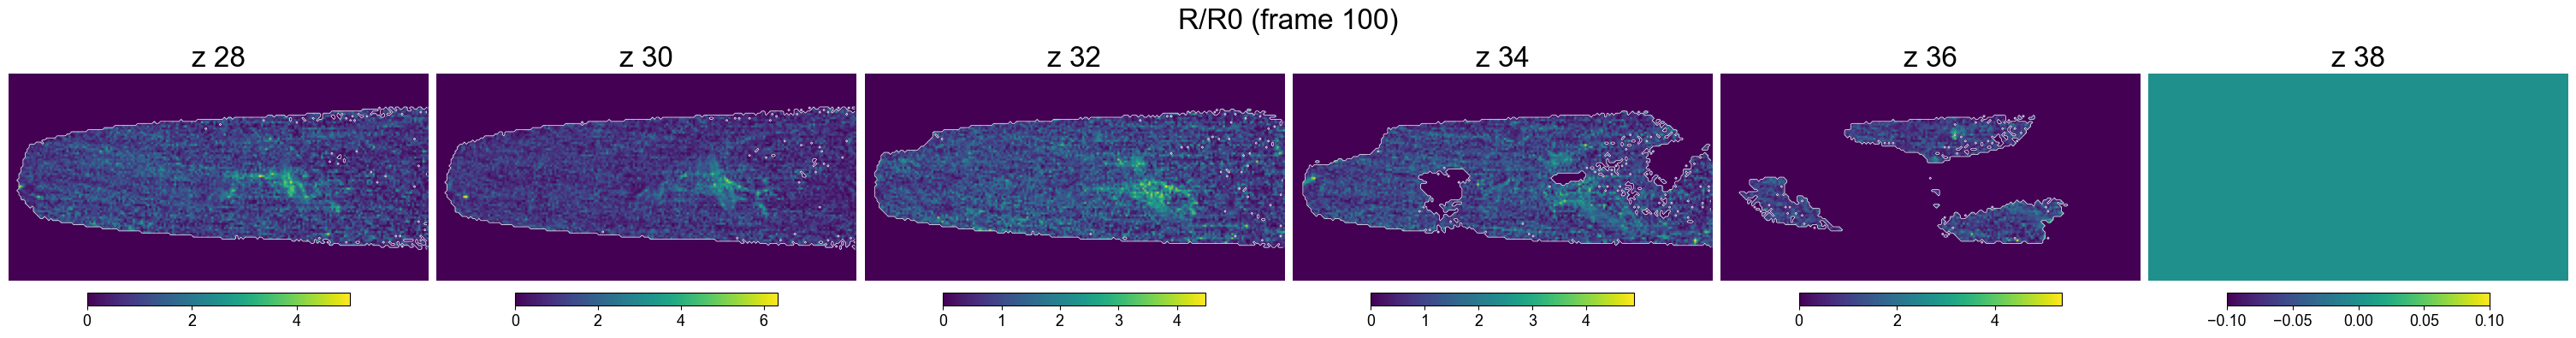

In [87]:
%matplotlib inline
plt.close('all')

# Plot representative z-slices at a chosen frame
# Use a frame index relative to the subsetted data (0 to T-1 where T = len(good_frames))
frame_to_show = 100  # Relative to good_frames start
print(f"Showing frame {frame_to_show} (original frame {original_frame_indices[frame_to_show]})")

fig1 = plot_representative_slices(g5_4d, z_with_roi, mask_3d, frame=frame_to_show, title="R/R0")
plt.show()

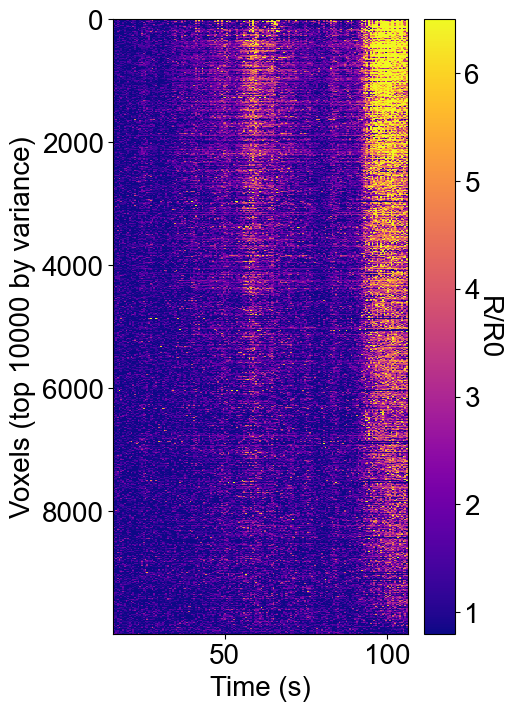

In [88]:
# Plot voxel heatmap over time (for selected voxels)
%matplotlib inline
fig2 = plot_voxel_heatmap(g5_preprocessed, config.fps, time_window=(30,200), max_voxels=config.top_n_voxels)
plt.show()

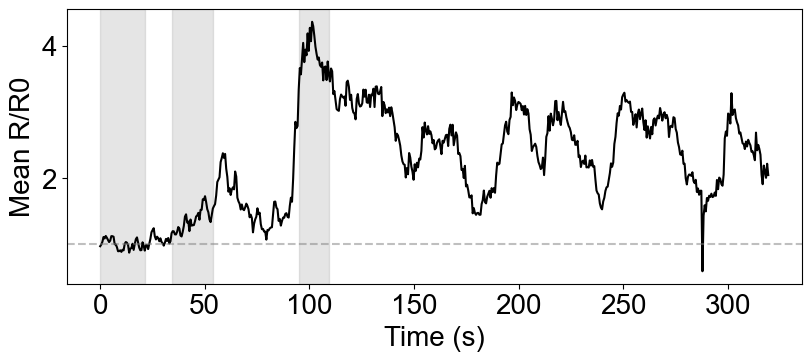

In [89]:
# Plot mean activity over time with epoch markers
fig3 = plot_mean_activity(g5_preprocessed, config.fps, adjusted_windows)
plt.show()

In [ ]:
# Plot activity distributions by epoch
fig4 = plot_epoch_distributions(g5_preprocessed, adjusted_windows)
plt.show()

# 6. Compute Coding Directions

In [90]:
# Compute epoch means (using 4D data for spatial info)
# Use adjusted_windows which account for good_frames subsetting
epoch_means = compute_epoch_means(g5_4d, adjusted_windows['baseline'], adjusted_windows['pre'], adjusted_windows['post'])

# Compute coding directions (optionally orthogonalize)
coding_directions = compute_coding_directions(epoch_means, orthogonalize=False)

print(f"\nCoding directions computed successfully.")

  Coding direction cosine similarities:
    pre-post: 0.6258
    pre-encounter: 0.5064
    post-encounter: 0.9895

Coding directions computed successfully.


# 7. Visualize Coding Directions (Spatial)

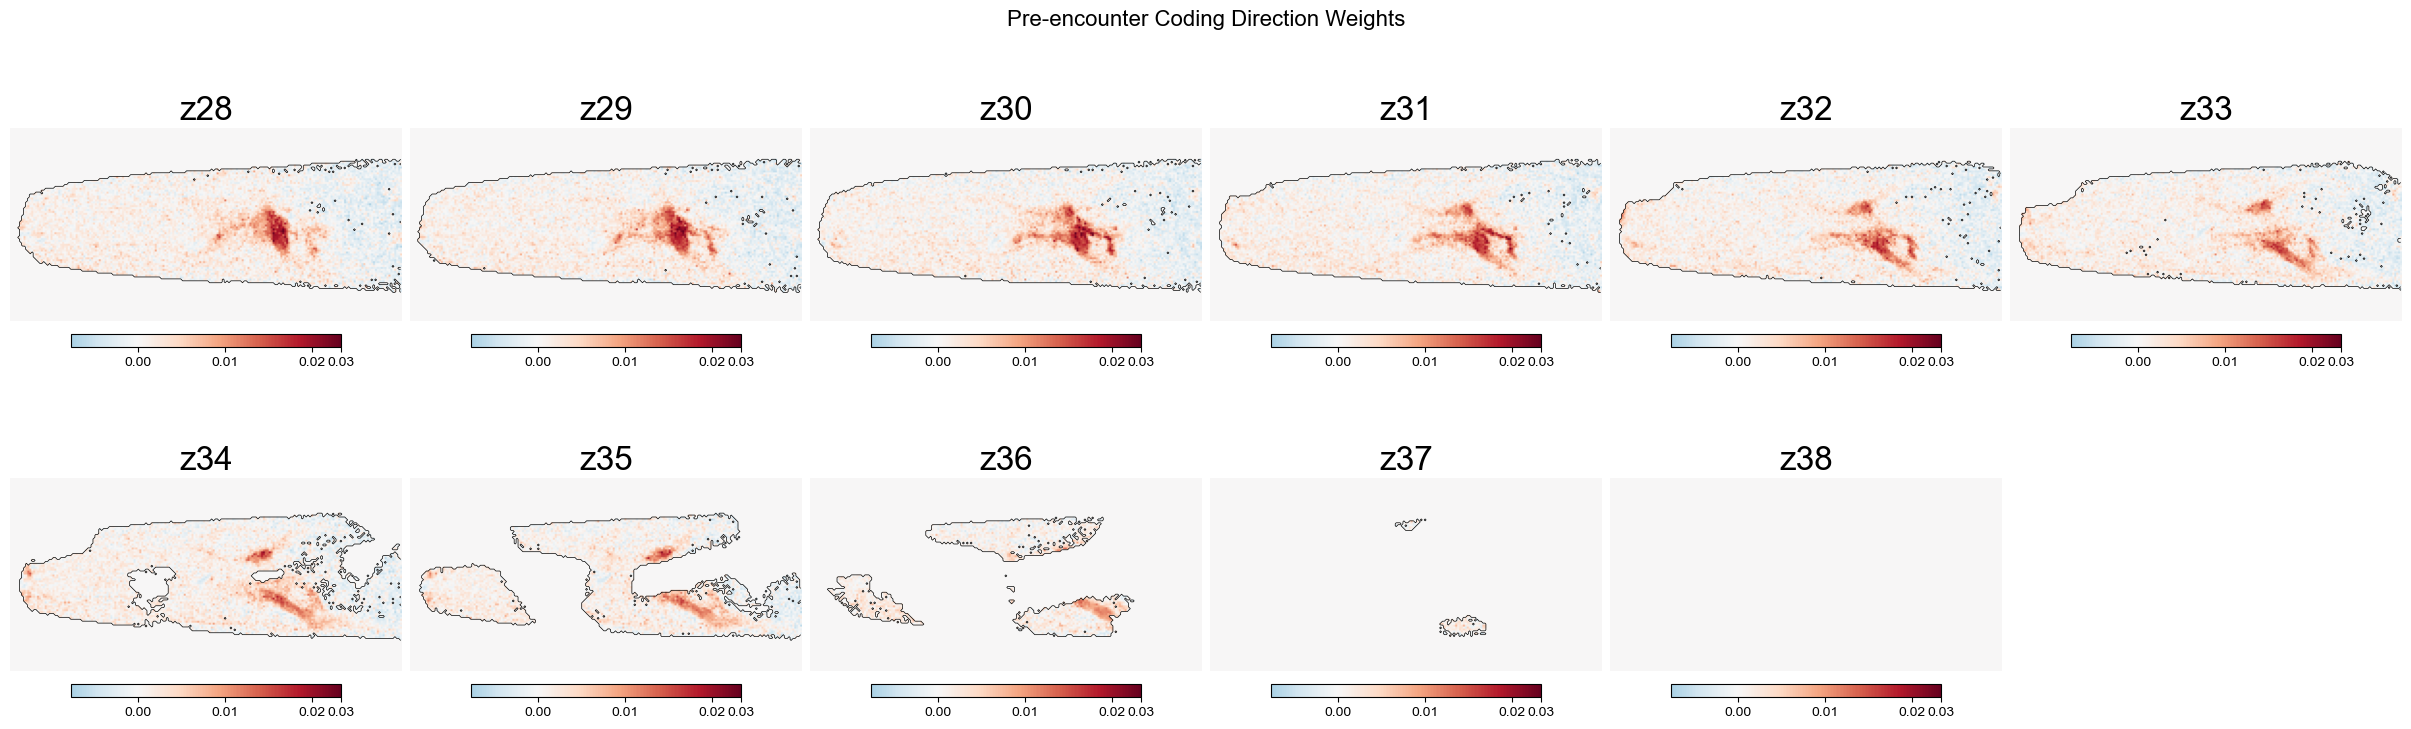

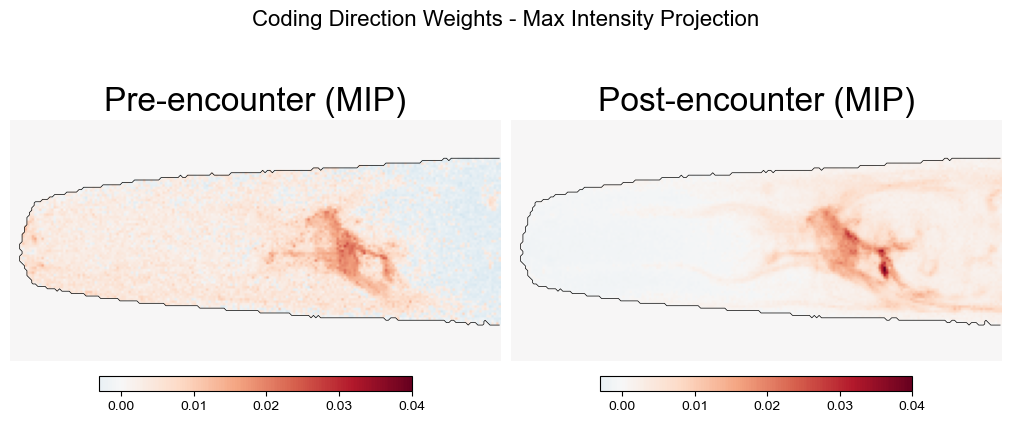

In [92]:
# Plot spatial distribution of coding direction weights for all z slices
# Use dir_names=['pre'] for pre-encounter only, or dir_names=['pre', 'post', 'encounter'] for all
%matplotlib inline
fig5 = plot_coding_directions_spatial(coding_directions, mask_3d, z_with_roi, spatial_shape, 
                                       dir_names=['pre'], cmap="RdBu_r", contour_color='black', cols_per_row=6)
plt.show()

# Plot max intensity projection of coding direction weights
fig5_mip = plot_coding_directions_mip(coding_directions, mask_3d, spatial_shape, 
                                       dir_names=['pre', 'post'], cmap="RdBu_r")
plt.show()

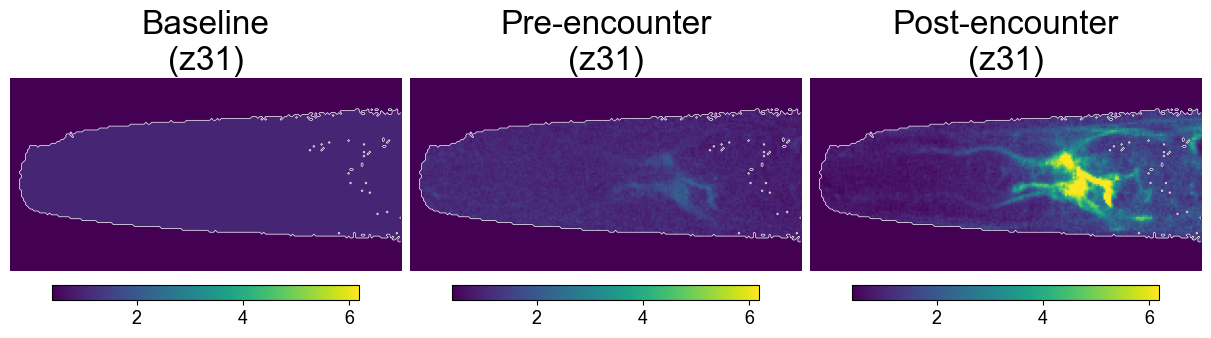

In [98]:
# Plot epoch mean activity maps
fig6 = plot_epoch_mean_comparison(epoch_means, mask_3d, z_with_roi, spatial_shape, slice=3)
plt.show()

In [ ]:
# Plot voxel weight distributions for each coding direction
fig7 = plot_voxel_weight_distributions(coding_directions, mask_flat)
plt.show()

In [ ]:
# Plot coding direction similarity matrix
fig8 = plot_coding_direction_similarity_matrix(coding_directions)
plt.show()

# 8. Project Data onto Coding Directions

In [ ]:
# Flatten 4D data for projections (use all data, not just selected voxels)
g5_flat_for_proj = g5_4d.reshape(g5_4d.shape[0], -1)

# Project onto coding directions
projections_raw = project_onto_directions(g5_flat_for_proj, coding_directions, mask_flat)

# Normalize projections for visualization
projections_norm = normalize_projections(projections_raw, method='minmax')

print(f"Projection shapes:")
for name, proj in projections_raw.items():
    print(f"  {name}: {proj.shape}")

In [ ]:
# Plot projection time series
fig9 = plot_projections(projections_raw, config.fps, adjusted_windows, normalized=False)
plt.show()

In [ ]:
# Plot 2D projection scatter (colored by time)
fig10 = plot_projection_scatter_2d(projections_norm, config.fps)
plt.show()

# 9. Variance Explained Analysis

In [ ]:
# Compute variance explained by each coding direction
var_explained = compute_variance_explained(g5_flat_for_proj, coding_directions, mask_flat)

print(f"\nVariance Explained:")
print(f"  Pre-encounter:  {var_explained['pre']*100:.4f}%")
print(f"  Post-encounter: {var_explained['post']*100:.4f}%")
print(f"  Encounter:      {var_explained['encounter']*100:.4f}%")
print(f"  Total variance: {var_explained['total']:.4f}")

In [ ]:
# Plot variance explained bar chart

# swap values for pre and post encounter variance explained before plotting
var_explained_swapped = {
    'pre': var_explained['post'],
    'post': var_explained['pre'],
    'encounter': var_explained['encounter']
}
fig11 = plot_variance_explained(var_explained_swapped)
plt.show()

# 10. Data Reconstruction from Coding Directions

Reconstruct the data using projections onto coding directions:
$$\hat{X}(t) = \sum_i \langle X(t), d_i \rangle \cdot d_i$$

This allows us to visualize what each coding direction "captures" and compare reconstruction quality.

In [ ]:
# Compute reconstructions from different direction combinations
reconstructions = {}

# Single directions
reconstructions['Pre'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre'])
reconstructions['Post'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['post'])
reconstructions['Encounter'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['encounter'])

# Combinations
reconstructions['Pre+Post'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre', 'post'])
reconstructions['All'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre', 'post', 'encounter'])

# # Compute reconstruction errors for each
# print("Reconstruction Error Metrics:")
# print("-" * 60)
# for label, recon in reconstructions.items():
#     error = compute_reconstruction_error(g5_flat_for_proj, recon, mask_flat)
#     print(f"{label:15s}  MSE: {error['mse']:.6f}  R²: {error['r_squared']:.4f}  Corr: {error['correlation']:.4f}")

In [ ]:
# Plot spatial reconstruction comparison for a single frame
frame_to_reconstruct = 160  # Choose a frame in post-encounter period

fig_recon = plot_reconstruction_spatial(
    g5_4d, reconstructions['Pre'], mask_3d, mask_flat, 
    z_with_roi, frame=frame_to_reconstruct, direction_label="All directions"
)
plt.show()

In [ ]:
# Compare reconstructions from different direction combinations
fig_compare = plot_reconstruction_comparison(
    g5_4d, 
    {'Pre': reconstructions['Pre'], 'Post': reconstructions['Post'], 'All': reconstructions['All']},
    mask_3d, mask_flat, z_with_roi, frame=frame_to_reconstruct
)
plt.show()

In [ ]:
# Plot mean activity time series: original vs reconstructions
fig_ts = plot_reconstruction_timeseries(
    g5_4d, 
    {'Pre': reconstructions['Pre'], 'Post': reconstructions['Post'], 'All': reconstructions['All']},
    mask_flat, config.fps, adjusted_windows
)
plt.show()

In [ ]:
# plot interactive spatial reconstructions

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage
from microfilm.microanim import Microanimpanel

T,Z,H,W = g5_4d.shape
recon = reconstructions['Encounter']
# reshape recon to TZHW
n_total_voxels = Z * H * W
recon_full_flat = np.zeros((T, n_total_voxels), dtype=recon.dtype)
recon_full_flat[:, mask_flat] = recon
recon_reshape = recon_full_flat.reshape(T, Z, H, W)

recon_mip = np.max(recon_reshape, axis=1) # THW

%matplotlib widget

plt.close('all')

mn = 0
mx = 20
fs = 3
dpi = 300


anim = Microanim(
        data=recon_mip[np.newaxis,:,:,:], cmaps=['viridis'], flip_map=False, fig_scaling=fs, dpi=dpi,
        rescale_type='limits', limits=[mn, mx])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')

anim.ui

# 11. Summary and Export

In [ ]:
# Print analysis summary
print("=" * 60)
print("CODING DIRECTIONS ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Data path: {config.data_path}")
print(f"  Preprocessing: {config.preprocess_method}")
print(f"  Top N voxels: {config.top_n_voxels or 'all'}")
print(f"  FPS: {config.fps:.3f}")

print(f"\nEpoch Windows (original frame indices):")
print(f"  Baseline:      {config.baseline_window}")
print(f"  Pre-encounter: {config.pre_window}")
print(f"  Post-encounter: {config.post_window}")

print(f"\nAdjusted Epoch Windows (after good_frames subsetting):")
print(f"  Baseline:      {adjusted_windows['baseline']}")
print(f"  Pre-encounter: {adjusted_windows['pre']}")
print(f"  Post-encounter: {adjusted_windows['post']}")

print(f"\nGood Frames:")
print(f"  Range: {original_frame_indices[0]} to {original_frame_indices[-1]} ({len(original_frame_indices)} frames)")

print(f"\nData Dimensions:")
print(f"  Original shape: {g5_4d.shape} (T, Z, H, W)")
print(f"  Z slices with ROI: {len(z_with_roi)}")
print(f"  Valid voxels: {np.sum(mask_flat)}")

print(f"\nCoding Direction Similarities:")
sims = coding_directions['similarities']
print(f"  Pre-Post:      {sims['pre_post']:.4f}")
print(f"  Pre-Encounter: {sims['pre_enc']:.4f}")
print(f"  Post-Encounter: {sims['post_enc']:.4f}")

print(f"\nVariance Explained:")
print(f"  Pre-encounter:  {var_explained['pre']*100:.4f}%")
print(f"  Post-encounter: {var_explained['post']*100:.4f}%")
print(f"  Encounter:      {var_explained['encounter']*100:.4f}%")

print(f"\nReconstruction Quality (R²):")
for label, recon in reconstructions.items():
    error = compute_reconstruction_error(g5_flat_for_proj, recon, mask_flat)
    print(f"  {label:15s}: {error['r_squared']*100:.4f}%")
print("=" * 60)

In [ ]:
# Optional: Save results to file
save_results = True  # Set to True to save

if save_results:
    import os
    results_dir = os.path.join(config.data_path, 'coding_directions_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save coding directions
    np.save(os.path.join(results_dir, 'pre_coding_direction.npy'), coding_directions['pre'])
    np.save(os.path.join(results_dir, 'post_coding_direction.npy'), coding_directions['post'])
    np.save(os.path.join(results_dir, 'encounter_coding_direction.npy'), coding_directions['encounter'])
    
    # Save projections
    np.save(os.path.join(results_dir, 'projections_pre.npy'), projections_raw['pre'])
    np.save(os.path.join(results_dir, 'projections_post.npy'), projections_raw['post'])
    np.save(os.path.join(results_dir, 'projections_encounter.npy'), projections_raw['encounter'])
    
    # Save variance explained as text
    with open(os.path.join(results_dir, 'variance_explained.txt'), 'w') as f:
        f.write(f"Pre-encounter: {var_explained['pre']*100:.4f}%\n")
        f.write(f"Post-encounter: {var_explained['post']*100:.4f}%\n")
        f.write(f"Encounter: {var_explained['encounter']*100:.4f}%\n")
    
    print(f"Results saved to: {results_dir}")
else:
    print("Set save_results = True to save results to disk.")